# Loan Approval Prediction - Neural Network

In this notebook we're using both the Kaggle Competition data (train.csv) but **also** the original data from which Kaggle created the competition (credit_risk_dataset.csv).

This notebook specifically looks at training a Neural Network with Keras. 

In [150]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
from datetime import datetime
import random
import seaborn as sns
import warnings
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import tensorflow as tf
import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Input, Flatten, Concatenate, Dropout
# from tensorflow.keras.models import Model

from tqdm.notebook import tqdm
from scipy.stats import uniform, randint, boxcox

pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

kaggle_training = pd.read_csv('/home/sagemaker-user/ml-notebooks/kaggle/2024/2024.10 - Loan Approval Prediction/train.csv')
kaggle_training['competition_data'] = 1
kaggle_test = pd.read_csv('/home/sagemaker-user/ml-notebooks/kaggle/2024/2024.10 - Loan Approval Prediction/test.csv')
kaggle_test['competition_data'] = 1
original_training = pd.read_csv('/home/sagemaker-user/ml-notebooks/kaggle/2024/2024.10 - Loan Approval Prediction/credit_risk_dataset.csv')
original_training['competition_data'] = 0

kaggle_training = pd.concat([kaggle_training, original_training], axis=0)

# Basic variables that are going to be used later
target_var = 'loan_status'
id_var = 'id'

original_categorical_vars = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'competition_data']
original_continuous_vars =  ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

print("\n------------------------")
print(f"Number of Categorical Features: {len(original_categorical_vars)}")
print(f"Number of Continuous Features:  {len(original_continuous_vars)}")

# Drop Outliers
def drop_outliers(data): 
    cleaned = data.copy();
    cleaned = cleaned.drop_duplicates()
    cleaned['loan_int_rate'] = cleaned['loan_int_rate'].fillna(cleaned['loan_int_rate'].median())
    return cleaned[(cleaned['person_age'] < 120) & (cleaned['person_emp_length'] < 100)].reset_index(drop=True)


------------------------
Number of Categorical Features: 5
Number of Continuous Features:  7


In [82]:
kaggle_training.head(2)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,competition_data
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,1
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,1


---
# Feature Engineering & Data Preparation

## Scaling

In [10]:
def scale_feature(dataset, feature_name, trained_scaler): 
    """ Scales the specified feature and returns 
     - the scaled pandas Series
     - the scaler
    """
    if trained_scaler: 
        scaler = trained_scaler
    else: 
        scaler = StandardScaler()
    
    if trained_scaler: 
        transformed = scaler.transform(dataset[feature_name].to_numpy().reshape(-1, 1))
    else:     
        transformed = scaler.fit_transform(dataset[feature_name].to_numpy().reshape(-1, 1))
    
    return scaler, transformed.flatten()

def scale_continuous_features(dataset, trained_scalers={}, continuous_vars=original_continuous_vars): 
    """Scales all the continuous features of the dataset
    --- 
    Returns: 
     - a dict of {feature_name: Scaler}
     - the transformed dataframe as a copy
    """
    scaled_data = dataset.copy()
    scalers = {}
    
    for feature_name in continuous_vars: 
        
        # Scale the feature
        scaler, scaled_feature = scale_feature(scaled_data, feature_name, trained_scalers.get(feature_name, None))
        
        # Replace
        scaled_data[feature_name] = scaled_feature
        
        # Save the scaler
        scalers[feature_name] = scaler
        
    return scaled_data, scalers

## Encoding

In [152]:
def encode_feature(dataset, feature_name, trained_encoder=None): 
    """One-hot encoding of the specified feature
    
    ---- 
    Returns
     - encoder
     - encoded feature as a DataFrame
    """
    
    if trained_encoder: 
        encoder = trained_encoder
    else: 
        if feature_name == 'loan_grade':
            encoder = OrdinalEncoder()
        else:
            encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    
    if trained_encoder: 
        encoded_values = encoder.transform(dataset[feature_name].to_numpy().reshape(-1,1))
    else:
        encoded_values = encoder.fit_transform(dataset[feature_name].to_numpy().reshape(-1,1))
        
    feature_names = [f"{feature_name}_{num}" for num in range(encoded_values.shape[1])]
    
    return encoder, pd.DataFrame(encoded_values, columns=feature_names)

def encode_categorical_features(dataset, trained_encoders={}, categorical_vars=original_categorical_vars): 
    
    encoded_data = dataset.copy()
    encoders = {}
    
    for feature_name in categorical_vars:
        
        # Encode
        encoder, encoded_values = encode_feature(encoded_data, feature_name, trained_encoders.get(feature_name, None))
        
        # Drop the feature
        encoded_data = encoded_data.drop(columns=[feature_name])
        
        # Replace with new encoded feature
        encoded_data = pd.concat([encoded_data, encoded_values], axis=1)
        
        # Save encoder
        encoders[feature_name] = encoder
        
    return encoded_data, encoders

a = drop_outliers(kaggle_training)
prepared_training, trained_scalers = scale_continuous_features(a)
prepared_training, trained_encoders = encode_categorical_features(prepared_training)

prepared_training.head(2)

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_0,person_home_ownership_1,person_home_ownership_2,loan_intent_0,loan_intent_1,loan_intent_2,loan_intent_3,loan_intent_4,loan_grade_0,cb_person_default_on_file_0,competition_data_0
0,0.0,1.540463,-0.684267,-1.197256,-0.576782,0.225050,0.073283,2.025480,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,-0.922144,-0.203735,0.322434,-0.918752,0.834388,-0.955811,-0.943889,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0


## Transformations
This section will transform features, for example applying Box-Cox or log transforms to specific features. <br>
*Note that transorms should be applied **BEFORE** scaling*.

In [12]:
def apply_transforms(dataset): 
    
    transformed_data = dataset.copy()
    
    # 1. Log Transform of the Income feature 'person_income'
    transformed_data['person_income'] = np.log(transformed_data['person_income'])
    
    return transformed_data

## Binning

Some notes on the binning efficacy. 

* Binning `person_emp_length` has **not generated any advantages**. 
* **Big Advantages** in performance seem to appear (see below experiment) when binning: `loan_int_rate` and `loan_percent_income`. This last one is **particularly important**. 

In [83]:
def apply_binning(dataset): 
    
    binned_data = dataset.copy()
    
    binned_data['person_income_binned'] = pd.cut(binned_data['person_income'], bins=[0, 10.585, 10.992, 11.4, float('inf')])
    binned_data['person_age_binned'] = pd.cut(binned_data['person_age'], bins=[0, 47.733, 60.533, 69, float('inf')])
    binned_data['person_emp_length_binned'] = pd.cut(binned_data['person_emp_length'], bins=[0, 2.733, 19.133, 25.967, float('inf')])
    binned_data['loan_amnt_binned'] = pd.cut(binned_data['loan_amnt'], bins=[0, 12000, 22350, float('inf')])
    binned_data['loan_int_rate_binned'] = pd.cut(binned_data['loan_int_rate'], bins=[0, 11.353, 13.727, 14.32, 20.253, float('inf')])
    binned_data['loan_percent_income_binned'] = pd.cut(binned_data['loan_percent_income'], bins=[0, 0.304, 0.526, float('inf')])
    binned_data['cred_hist_binned'] = pd.cut(binned_data['cb_person_cred_hist_length'], bins=[0, 13.2, 20.667, 23.467, 26.267, float('inf')])
    
    # Make sure you add this to the categorical variables now
    updated_categorical_vars = original_categorical_vars + [
        'person_income_binned', 
        'person_age_binned', 
        'person_emp_length_binned', 
        'loan_amnt_binned', 
        'loan_int_rate_binned', 
        'loan_percent_income_binned', 
        'cred_hist_binned'
    ]
    
    return binned_data, updated_categorical_vars

## Feature Engineering

In [106]:
kaggle_training.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'competition_data'],
      dtype='object')

In [131]:
def engineer_features(dataset, categorical_vars=original_categorical_vars, continuous_vars=original_continuous_vars): 
    
    enhanced_df = dataset.copy()
    
    work_age_threshold = 18
    adult_age = 18

    # New Continuous Features
    enhanced_df['perc_adult_age_emp'] = enhanced_df['person_emp_length'] / (enhanced_df['person_age'] - adult_age)
    enhanced_df['cred_hist_to_age_ratio'] = enhanced_df['cb_person_cred_hist_length'] / (enhanced_df['person_age'] - adult_age)
    enhanced_df['age_income_interaction'] = (enhanced_df['person_age'] * enhanced_df['person_income'])
    enhanced_df['risk_flag'] = (np.where((enhanced_df['cb_person_default_on_file'] == 'Y') & (enhanced_df['loan_grade'].isin(['D', 'E', 'F', 'G'])), 1, 0))
    enhanced_df['int_rate_to_loan_amt'] = (enhanced_df['loan_int_rate'] / enhanced_df['loan_amnt'])
    enhanced_df['loan_amt_to_credit_hist'] = (enhanced_df['loan_amnt'] / enhanced_df['cb_person_cred_hist_length'])
    enhanced_df['loan_to_adult_age'] = enhanced_df['loan_amnt'] / (enhanced_df['person_age'] - adult_age)
    enhanced_df['income_to_adult_age'] = enhanced_df['person_income'] / (enhanced_df['person_age'] - adult_age)
    
    enhanced_df['salary_per_years_worked'] = np.log(np.where(
        enhanced_df['person_emp_length'] == 0, 
        enhanced_df['person_income'],  # If emp_length is 0, take person_income
        enhanced_df['person_income'] / enhanced_df['person_emp_length']  # Else, perform the division
    ))
    
    # Some binning here too
    # enhanced_df['salary_per_years_worked_binned'] = pd.cut(enhanced_df['salary_per_years_worked'], bins=[0, 6.744, 7.842, 11.408, 12.779, float('inf')])
    enhanced_df['income_to_adult_age_binned'] = pd.qcut(enhanced_df['income_to_adult_age'], q=10)
    enhanced_df['loan_to_adult_age_binned'] = pd.qcut(enhanced_df['loan_to_adult_age'], q=10)
    enhanced_df['loan_amt_to_credit_hist_binned'] = pd.qcut(enhanced_df['loan_amt_to_credit_hist'], q=10)
    enhanced_df['int_rate_to_loan_amt_binned'] = pd.qcut(enhanced_df['int_rate_to_loan_amt'], q=10)
    
    # New Categorical Features
    enhanced_df['emp_age_inconsistent'] = enhanced_df['person_emp_length'] >= enhanced_df['person_age'] - work_age_threshold
    
    updated_continuous_vars = continuous_vars + [
        'perc_adult_age_emp',
        'salary_per_years_worked',
        'cred_hist_to_age_ratio',
        'age_income_interaction',
        'int_rate_to_loan_amt',
        'loan_amt_to_credit_hist',
        'loan_to_adult_age', 
        'income_to_adult_age'
    ]
    
    updated_categorical_vars = categorical_vars + [
        'emp_age_inconsistent', 
        # 'salary_per_years_worked_binned',
        'risk_flag',
        'income_to_adult_age_binned', 
        'loan_to_adult_age_binned', 
        'loan_amt_to_credit_hist_binned', 
        'int_rate_to_loan_amt_binned'
    ]
    
    return enhanced_df, updated_categorical_vars, updated_continuous_vars
    

---
# Modelling

## Common methods
Contains common training and scoring methods. 

In [158]:
def prep_data_for_training(training_data, return_tensors=True): 
    """Prepares the data for the training process. That includes: 
    1. Cleaning the dta
    2. Executing any transformation (e.g. log transforms, binning, etc.)
    3. Feature Engineering
    4. Train-Test split
    """
    dataset = training_data.copy()

    # 0. Drop outliers
    dataset = drop_outliers(dataset)

    # 1. Data Preparation
    # ----------------------------------------------------------------------
    # Transformations
    dataset = apply_transforms(dataset)

    # Binning
    dataset, updated_categorical_vars = apply_binning(dataset)

    # Feature Engineering
    dataset, updated_categorical_vars, updated_continuous_vars = engineer_features(dataset, categorical_vars=updated_categorical_vars)

    # Scaling & Encoding (to be done as last!)
    dataset, trained_scalers = scale_continuous_features(dataset, continuous_vars=updated_continuous_vars)
    dataset, trained_encoders = encode_categorical_features(dataset, categorical_vars=updated_categorical_vars)
    
    X = dataset.drop(columns=[id_var, target_var]).to_numpy()
    y = dataset[target_var].to_numpy()

    if return_tensors: 
        return {
            'trained_scalers': trained_scalers, 
            'trained_encoders': trained_encoders, 
            'X_train': tf.convert_to_tensor(X, dtype=tf.float32),
            'y_train': tf.convert_to_tensor(y, dtype=tf.float32)
        }
    else: 
        return {
            'trained_scalers': trained_scalers, 
            'trained_encoders': trained_encoders,
            'dataset': dataset
        }



prep_data_for_training(kaggle_training, return_tensors=False, split=False)['dataset']

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,perc_adult_age_emp,cred_hist_to_age_ratio,age_income_interaction,int_rate_to_loan_amt,loan_amt_to_credit_hist,loan_to_adult_age,income_to_adult_age,salary_per_years_worked,person_home_ownership_0,person_home_ownership_1,person_home_ownership_2,loan_intent_0,loan_intent_1,loan_intent_2,loan_intent_3,loan_intent_4,loan_grade_0,cb_person_default_on_file_0,competition_data_0,person_income_binned_0,person_income_binned_1,person_income_binned_2,person_age_binned_0,person_age_binned_1,person_age_binned_2,person_emp_length_binned_0,person_emp_length_binned_1,person_emp_length_binned_2,person_emp_length_binned_3,loan_amnt_binned_0,loan_amnt_binned_1,loan_int_rate_binned_0,loan_int_rate_binned_1,loan_int_rate_binned_2,loan_int_rate_binned_3,loan_percent_income_binned_0,loan_percent_income_binned_1,loan_percent_income_binned_2,cred_hist_binned_0,cred_hist_binned_1,cred_hist_binned_2,cred_hist_binned_3,emp_age_inconsistent_0,risk_flag_0,income_to_adult_age_binned_0,income_to_adult_age_binned_1,income_to_adult_age_binned_2,income_to_adult_age_binned_3,income_to_adult_age_binned_4,income_to_adult_age_binned_5,income_to_adult_age_binned_6,income_to_adult_age_binned_7,income_to_adult_age_binned_8,loan_to_adult_age_binned_0,loan_to_adult_age_binned_1,loan_to_adult_age_binned_2,loan_to_adult_age_binned_3,loan_to_adult_age_binned_4,loan_to_adult_age_binned_5,loan_to_adult_age_binned_6,loan_to_adult_age_binned_7,loan_to_adult_age_binned_8,loan_amt_to_credit_hist_binned_0,loan_amt_to_credit_hist_binned_1,loan_amt_to_credit_hist_binned_2,loan_amt_to_credit_hist_binned_3,loan_amt_to_credit_hist_binned_4,loan_amt_to_credit_hist_binned_5,loan_amt_to_credit_hist_binned_6,loan_amt_to_credit_hist_binned_7,loan_amt_to_credit_hist_binned_8,int_rate_to_loan_amt_binned_0,int_rate_to_loan_amt_binned_1,int_rate_to_loan_amt_binned_2,int_rate_to_loan_amt_binned_3,int_rate_to_loan_amt_binned_4,int_rate_to_loan_amt_binned_5,int_rate_to_loan_amt_binned_6,int_rate_to_loan_amt_binned_7,int_rate_to_loan_amt_binned_8
0,0.0,1.540463,-0.984618,-1.197256,-0.576782,0.225050,0.073283,2.025480,0,-1.212127,0.556723,1.207582,0.076541,-0.916221,-0.927887,-1.270044,1.447658,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,-0.922144,-0.034674,0.322434,-0.918752,0.834388,-0.955811,-0.943889,0,1.738252,-0.532560,-0.890550,0.913830,-0.161095,-0.274047,1.541430,-0.640013,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.227073,-1.378686,0.828997,-0.576782,-0.623436,0.484920,1.035690,0,0.218360,1.348928,-0.071263,-0.177540,-0.833844,-0.708416,-0.776974,-1.058585,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,0.391246,0.416331,2.348687,0.449128,0.100562,0.073283,-0.201547,0,1.082612,-0.915826,0.456992,-0.505687,0.031119,-0.274047,-0.781842,-1.627929,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,-0.922144,0.104771,-0.690693,-0.576782,-1.272086,-0.647083,-0.696442,0,-0.228667,0.617238,-0.86882

In [160]:

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: 
            logs = logs or {}
            auc = logs.get('auc', 0)
            val_auc = logs.get('val_auc', 0)
            tqdm.write(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}, auc={auc:.6f}, val_auc={val_auc:.6f}")


def train_score_model(prepared_data, model, epochs=50, batch_size=32, validation_split=.2): 

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(name="auc")])

    model.summary()

    r = model.fit(
        prepared_data['X_train'], 
        prepared_data['y_train'], 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=validation_split, 
        callbacks=[CustomCallback()],
        verbose=0)

    return {
        'model': model, 
        'trained_scalers': prepared_data['trained_scalers'],
        'trained_encoders': prepared_data['trained_encoders'], 
        'fitting_result': r
    }

## Baseline
Simple Neural Network to get a baseline score to compare further experiments with. 

In [161]:
def train_baseline_model(dataset, epochs=3): 
    # 1. Prepare data for training
    prepped = prep_data_for_training(dataset)

    # 2. Model Architecture
    i = keras.layers.Input(shape=(prepped['X_train'].shape[1],))
    x = keras.layers.Dense(50, activation="relu")(i)

    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.models.Model(inputs=i, outputs=output)

    # 3. Train and Score
    return train_score_model(prepped, model, epochs=epochs, batch_size=64)
    

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 87)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 50)             │         4,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451 (17.39 KB)

 Trainable params: 4,451 (17.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1: loss=0.2755, val_loss=0.2438, auc=0.890139, val_auc=0.910379


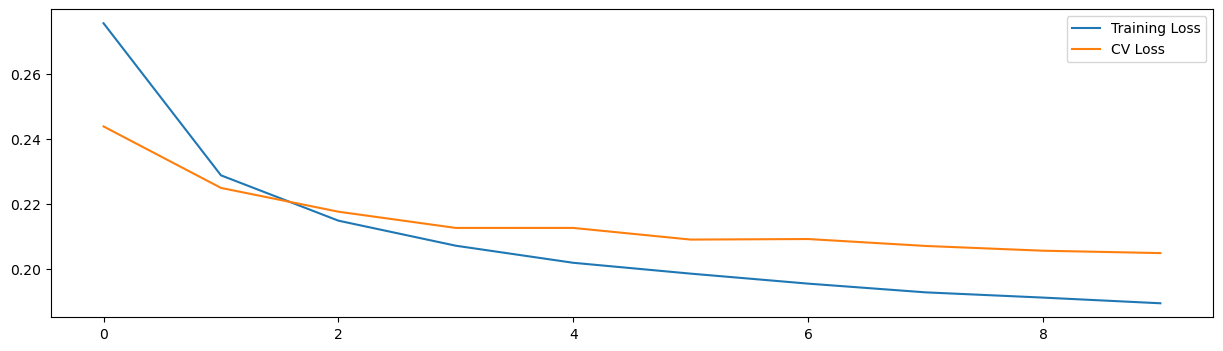

In [163]:

baseline_model = train_baseline_model(kaggle_training, epochs=10)

plt.figure(figsize=(15, 4))
sns.lineplot(baseline_model['fitting_result'].history["loss"], label="Training Loss")
sns.lineplot(baseline_model['fitting_result'].history["val_loss"], label="CV Loss")
plt.legend()

## Deeper Net

Experiment notes on a Network: 

1. When doing one-hot, dropping one of the categories (avoiding collinearity) **has helped** the model perform better.
2. 

In [170]:
def train_deeper_network(dataset, epochs=3, plot_learning_curves=False, start_plot_from_epoch=0): 
    # 1. Prepare data for training
    prepped = prep_data_for_training(dataset)

    # 2. Model Architecture
    i = keras.layers.Input(shape=(prepped['X_train'].shape[1],))
    x = keras.layers.Dense(87, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu", )(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.models.Model(inputs=i, outputs=output)

    # 3. Train and Score
    trained_model = train_score_model(prepped, model, epochs=epochs, batch_size=256, validation_split=0.2)

    if plot_learning_curves: 
        plt.figure(figsize=(15, 4))
        sns.lineplot(trained_model['fitting_result'].history["loss"][start_plot_from_epoch:], label="Training Loss")
        sns.lineplot(trained_model['fitting_result'].history["val_loss"][start_plot_from_epoch:], label="CV Loss")
        plt.legend()

    return trained_model
    

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 87)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,977 (11.63 KB)

 Trainable params: 2,913 (11.38 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1: loss=0.5554, val_loss=0.2952, auc=0.782781, val_auc=0.899234
Epoch 11: loss=0.2260, val_loss=0.2011, auc=0.914507, val_auc=0.929370
Epoch 21: loss=0.2148, val_loss=0.1930, auc=0.919420, val_auc=0.931462
Epoch 31: loss=0.2099, val_loss=0.1913, auc=0.923301, val_auc=0.931965
Epoch 41: loss=0.2080, val_loss=0.1884, auc=0.923683, val_auc=0.932935
Epoch 51: loss=0.2065, val_loss=0.1878, auc=0.924182, val_auc=0.932822
Epoch 61: loss=0.2055, val_loss=0.1873, auc=0.924643, val_auc=0.933236


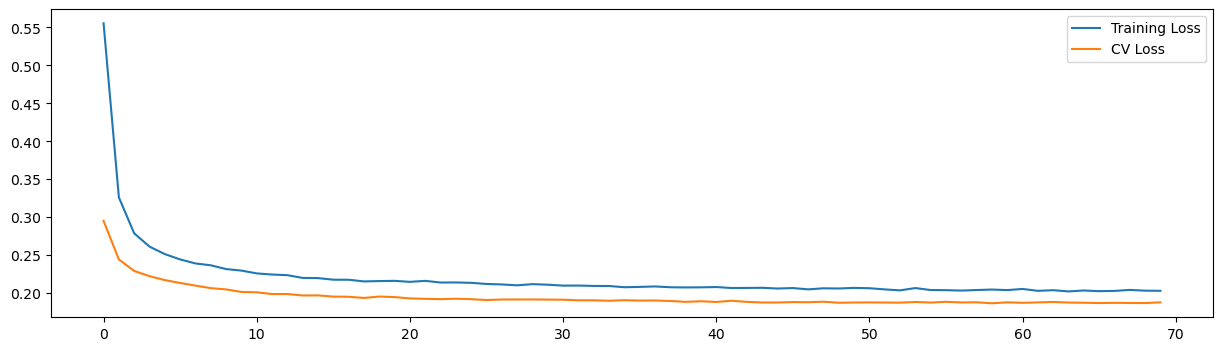

In [171]:
deeper_model = train_deeper_network(kaggle_training, epochs=70, plot_learning_curves=True, start_plot_from_epoch=0)

---
# Submission

In [140]:
def predict_and_submit(model, experiment_name=None, save_to_file=True):
    """Prepares the data for submission, predicts using the provided model and saves as CSV
    ----
    Params
    - model: dict
    Has to have the following keys: 
        - 'model' with the trained model
        - 'trained_scalers' with the trained scalers
        - 'trained_encoders' with the trained encoders
    """
    submission_data = kaggle_test.copy()

    # 1. Data Preparation
    # ----------------------------------------------------------------------
    # Transformations
    submission_data = apply_transforms(submission_data)

    # Binning
    submission_data, updated_categorical_vars = apply_binning(submission_data)

    # Feature Engineering
    submission_data, updated_categorical_vars, updated_continuous_vars = engineer_features(submission_data, categorical_vars=updated_categorical_vars)

    submission_data, _ = scale_continuous_features(submission_data, model['trained_scalers'], continuous_vars=updated_continuous_vars)
    submission_data, _ = encode_categorical_features(submission_data, model['trained_encoders'], categorical_vars=updated_categorical_vars)

    # 2. Inference
    # ----------------------------------------------------------------------
    X_sub = tf.convert_to_tensor(submission_data.drop(columns=[id_var]), dtype=tf.float32)

    y_sub_pred = model['model'].predict(X_sub)

    submission_data[target_var] = y_sub_pred

    # 3. Submission
    # ----------------------------------------------------------------------
    filename = 'submission.csv'
    if experiment_name:
        filename = f"{experiment_name}.csv"

    if save_to_file:
        submission_data[[id_var, target_var]].to_csv(filename, index=False)

    return submission_data


In [141]:
predict_and_submit(deeper_model, experiment_name="Neural Net")

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  54/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step


,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,perc_adult_age_emp,cred_hist_to_age_ratio,age_income_interaction,int_rate_to_loan_amt,loan_amt_to_credit_hist,loan_to_adult_age,income_to_adult_age,salary_per_years_worked,person_home_ownership_0,person_home_ownership_1,person_home_ownership_2,loan_intent_0,loan_intent_1,loan_intent_2,loan_intent_3,loan_intent_4,loan_grade_0,loan_grade_1,loan_grade_2,loan_grade_3,loan_grade_4,loan_grade_5,cb_person_default_on_file_0,competition_data_0,person_income_binned_0,person_income_binned_1,person_income_binned_2,person_age_binned_0,person_age_binned_1,person_age_binned_2,person_emp_length_binned_0,person_emp_length_binned_1,person_emp_length_binned_2,person_emp_length_binned_3,loan_amnt_binned_0,loan_amnt_binned_1,loan_int_rate_binned_0,loan_int_rate_binned_1,loan_int_rate_binned_2,loan_int_rate_binned_3,loan_percent_income_binned_0,loan_percent_income_binned_1,loan_percent_income_binned_2,cred_hist_binned_0,cred_hist_binned_1,cred_hist_binned_2,cred_hist_binned_3,emp_age_inconsistent_0,risk_flag_0,income_to_adult_age_binned_0,income_to_adult_age_binned_1,income_to_adult_age_binned_2,income_to_adult_age_binned_3,income_to_adult_age_binned_4,income_to_adult_age_binned_5,income_to_adult_age_binned_6,income_to_adult_age_binned_7,income_to_adult_age_binned_8,loan_to_adult_age_binned_0,loan_to_adult_age_binned_1,loan_to_adult_age_binned_2,loan_to_adult_age_binned_3,loan_to_adult_age_binned_4,loan_to_adult_age_binned_5,loan_to_adult_age_binned_6,loan_to_adult_age_binned_7,loan_to_adult_age_binned_8,loan_amt_to_credit_hist_binned_0,loan_amt_to_credit_hist_binned_1,loan_amt_to_credit_hist_binned_2,loan_amt_to_credit_hist_binned_3,loan_amt_to_credit_hist_binned_4,loan_amt_to_credit_hist_binned_5,loan_amt_to_credit_hist_binned_6,loan_amt_to_credit_hist_binned_7,loan_amt_to_credit_hist_binned_8,int_rate_to_loan_amt_binned_0,int_rate_to_loan_amt_binned_1,int_rate_to_loan_amt_binned_2,int_rate_to_loan_amt_binned_3,int_rate_to_loan_amt_binned_4,int_rate_to_loan_amt_binned_5,int_rate_to_loan_amt_binned_6,int_rate_to_loan_amt_binned_7,int_rate_to_loan_amt_binned_8,loan_status
0,58645,-0.757970,0.387250,-0.437411,2.671932,1.623906,2.028562,-0.943889,-0.031975,-0.992480,-0.665369,-0.679580,4.884523,3.548401,0.891043,0.210504,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999819
1,58646,-0.265449,1.054715,0.322434,0.107158,0.614895,-0.647083,-0.448995,0.263062,-0.532560,-0.064124,-0.304286,0.079172,-0.035144,-0.132201,-0.582533,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015630
2,58647,-0.265449,-1.296178,0.069152,-0.918752,2.092375,-0.338355,-0.943889,0.017198,-1.682359,-0.496925,1.478890,-0.161095,-0.751853,-0.319489,-0.492453,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.835526
3,58648,0.883768,-0.263727,-0.184129,-0.405797,-0.623436,-0.235446,0.293348,-0.687615,-0.685867,0.777067,-0.302268,-0.641630,-0.783707,-1.050250,-0.168153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0